# Machine Learning COS-623 - Terceiro Trimestre de 2017
## Terceira e Quarta Listas de Exercı́cios (Graduação e Pós-Graduação)



In [7]:
# Importando bibliotecas úteis
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn

In [15]:
## Lendo o dataset e separando os dados em 1000 dados de treino e 172 dados de teste
df = pd.read_csv("Dados-medicos.txt",sep=" ")
df = df.drop('Unnamed: 1', 1)
df = df.drop('Unnamed: 2', 1)

train = df.sample(frac = 0.85324232082,random_state=200)
test  = df.drop(train.index)
list(test)

['IDADE', 'Peso', 'Carga_Final', 'VO2_medido_máximo']

### Questão 1.1

   features         w
0         0  0.000000
1         1  0.133087
O RMSE com polinômio de grau 1 foi de 5.248248
O NLL com polinômio de grau 1 foi de -571.207806 

   features         w
0         0  0.000000
1         1  0.135884
2         2 -0.000007
O RMSE com polinômio de grau 2 foi de 5.239117
O NLL com polinômio de grau 2 foi de -571.116067 

   features             w
0         0  0.000000e+00
1         1  1.238605e-01
2         2  6.021022e-05
3         3 -1.115425e-07
O RMSE com polinômio de grau 3 foi de 5.243538
O NLL com polinômio de grau 3 foi de -571.160462 

   features             w
0         0  0.000000e+00
1         1  2.163564e-01
2         2 -7.686770e-04
3         3  2.795914e-06
4         4 -3.451295e-09
O RMSE com polinômio de grau 4 foi de 5.264564
O NLL com polinômio de grau 4 foi de -571.372131 



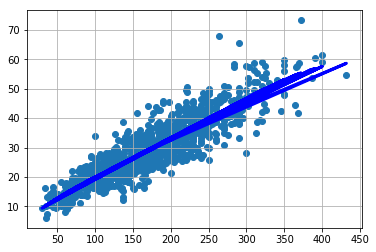

In [49]:
from sklearn.linear_model import LinearRegression

## Vamos criar X_ e test_ para ser datasets que possuem os valores das nossas variaveis x (carga) elevado a n

data = train[['Carga_Final','VO2_medido_máximo']]
X_ = data.drop('VO2_medido_máximo', axis = 1)

testData = test[['Carga_Final','VO2_medido_máximo']]
test_ = testData.drop('VO2_medido_máximo', axis = 1)

polyDegree = 4
poly = PolynomialFeatures(degree=polyDegree)

X_ = poly.fit_transform(X_)
    
test_ = poly.fit_transform(test_)

X_ = pd.DataFrame(data=X_[0:,0:],index=X_[0:,0])

test_ = pd.DataFrame(data=test_[0:,0:],index=test_[0:,0]) 

## Executando uma regressao polinomial para cada grau de polinomio <= polyDegree
lm = LinearRegression()
for i in range (1,polyDegree+1):
    X = X_.iloc[:,0:i+1]
    test_X = test_.iloc[:,0:i+1]
    lm.fit(X,data.VO2_medido_máximo)
    print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))
    rmse =  np.sqrt(np.mean( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 ))
    print("O RMSE com polinômio de grau %i foi de %f" % (i,rmse)) 
    var = test[['VO2_medido_máximo']].var()
    nll = -(len(test)/2)*np.log(2*np.pi*var) - (1/(2*var))* np.sum( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 )
    print("O NLL com polinômio de grau %i foi de %f \n" % (i,nll)) 

# plots graph
y = train[['VO2_medido_máximo']].values
x = train[['Carga_Final']].values
plt.scatter(x,y)
plt.plot(x, lm.predict(poly.fit_transform(x)), color='blue', linewidth=3)

plt.grid(True)
plt.savefig("test.png")
plt.show()

### Questão 1.2

In [35]:
# Vamos criar trainFeatures e testFeatures e aplicar sobre eles as transformações dados pelas base functions
# E.g., Para duas features a e b, para um polinomio de grau 2, as funções base serão:
# [1, a, b, a^2, ab, b^2]

trainData = train[['Peso', 'Carga_Final','VO2_medido_máximo']]
trainFeatures = trainData.drop('VO2_medido_máximo', axis = 1)

testData = test[['Peso', 'Carga_Final','VO2_medido_máximo']]
testFeatures = testData.drop('VO2_medido_máximo', axis = 1)

polyDegree = 4

# executa para todos os graus de 0 até polyDegree
for i in range (1,polyDegree+1):
    poly = PolynomialFeatures(degree=i)
    X = poly.fit_transform(trainFeatures)
    test_X = poly.fit_transform(testFeatures)

    X = pd.DataFrame(data=X[0:,0:],index=X[0:,0])
    test_X = pd.DataFrame(data=test_X[0:,0:],index=test_X[0:,0]) 

    w_list = []
    
    lm = LinearRegression()
    lm.fit(X,trainData.VO2_medido_máximo)
    w_list.append(lm.coef_)
    print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))
    rmse =  np.sqrt(np.mean( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 ))
    print("O RMSE com polinômio de grau %i foi de %f" % (i,rmse)) 
    var = test[['VO2_medido_máximo']].var()
    nll = -(len(test)/2)*np.log(2*np.pi*var) - (1/(2*var))* np.sum( (test.VO2_medido_máximo - lm.predict(test_X) ) **2 )
    print("O NLL com polinômio de grau %i foi de %f \n" % (i,nll)) 

   features         w
0         0  0.000000
1         1 -0.244736
2         2  0.142742
O RMSE com polinômio de grau 1 foi de 3.781242
O NLL com polinômio de grau 1 foi de -558.517666 

   features         w
0         0  0.000000
1         1 -0.488019
2         2  0.288877
3         3  0.002468
4         4 -0.001340
5         5 -0.000084
O RMSE com polinômio de grau 2 foi de 3.518761
O NLL com polinômio de grau 2 foi de -556.682002 

   features             w
0         0  0.000000e+00
1         1 -2.954695e-01
2         2  4.048171e-01
3         3  3.005451e-03
4         4 -4.721965e-03
5         5  1.081736e-04
6         6 -1.038018e-05
7         7  1.690830e-05
8         8  6.637688e-07
9         9 -3.940199e-07
O RMSE com polinômio de grau 3 foi de 3.535753
O NLL com polinômio de grau 3 foi de -556.796843 

    features             w
0          0  0.000000e+00
1          1  5.715251e-02
2          2  5.911783e-01
3          3 -8.479512e-04
4          4 -8.059560e-03
5          5 -7.